Standard deviation of RR intervals (in seconds): 0.05759
0.56 min
0.9 max
Number of abnormal RR intervals detected: 6


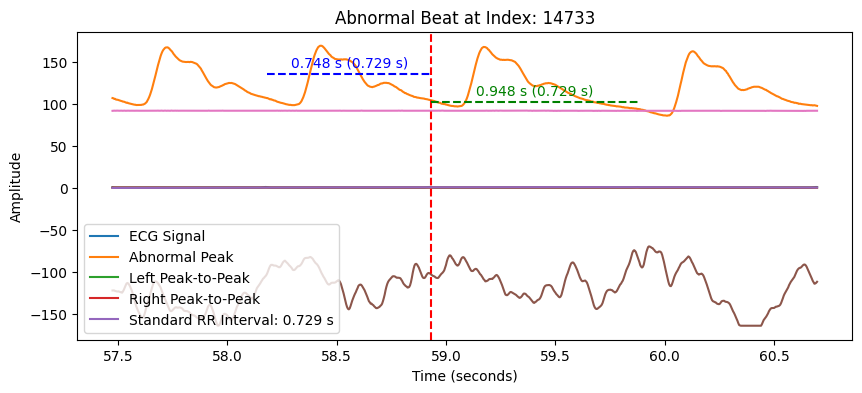

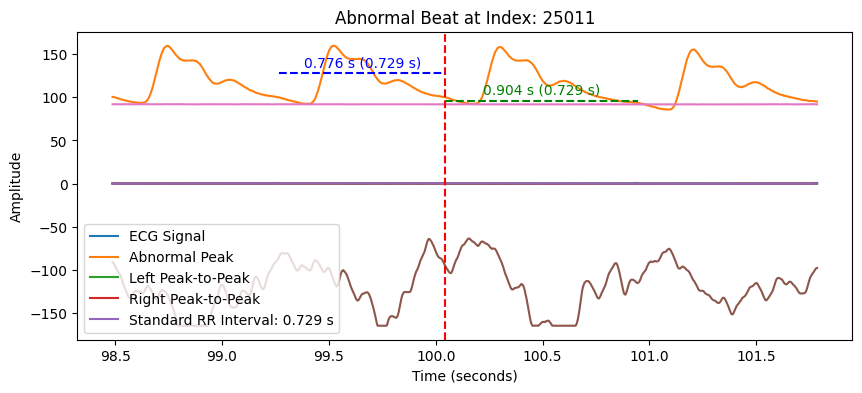

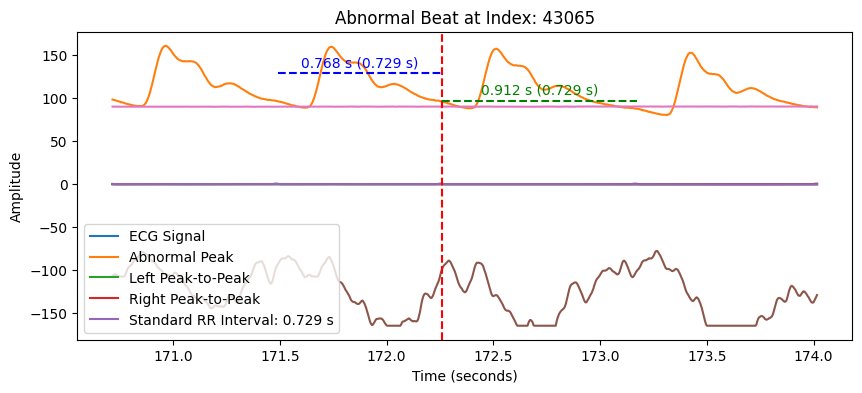

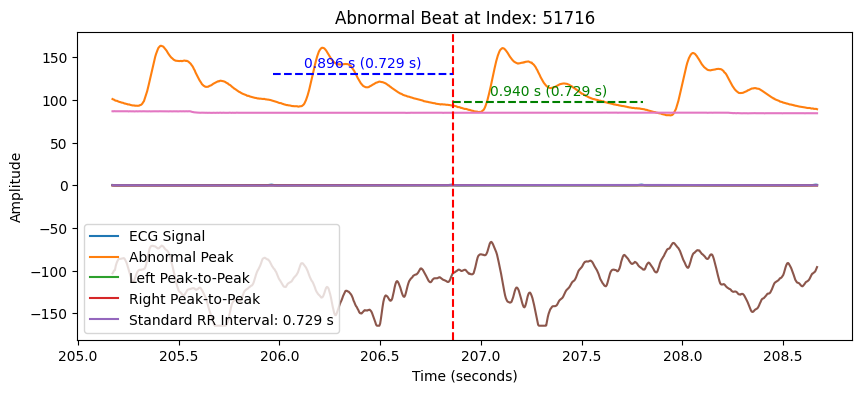

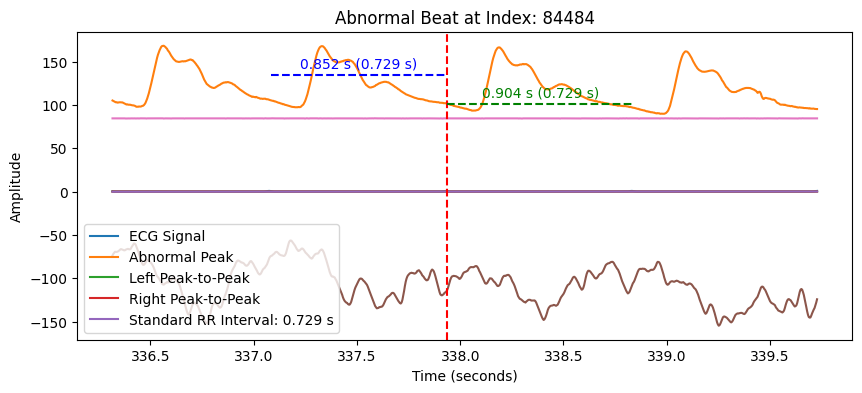

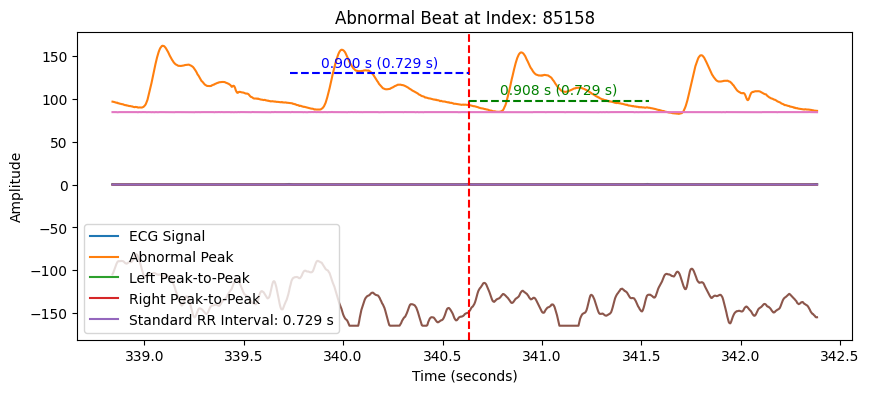

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy import signal
from scipy.signal import find_peaks

# Lowpass and Highpass filter settings
Lowpass_setting = 5  # in Hz
Highpass_setting = 20  # in Hz
window_size = 8  # Window size for moving average
quantile_threshold = 0.5  # Ignore the top 0.5% of the values

# Function to define the bandpass filter
def define_bandpass_filter(lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Function to apply a differentiation filter
def apply_differentiation_filter(signal):
    return np.diff(signal, n=1)

# Function to apply a squaring filter
def apply_squaring_filter(signal):
    return np.square(signal)

# Function to apply a moving average filter
def apply_moving_average_filter(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# Function to determine the threshold based on a quantile
def determine_threshold(signal, quantile):
    threshold_value = np.quantile(signal, quantile)
    top_values = signal[signal >= threshold_value]
    return np.mean(top_values)

# Function to detect peaks, ensuring no overlapping indices
def detect_peaks(signal, threshold, min_distance):
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance)
    detected_peaks = []
    
    for peak in peaks:
        if all(abs(peak - p) >= min_distance for p in detected_peaks):  # Check distance from previously detected peaks
            detected_peaks.append(peak)
    
    return np.array(detected_peaks)

# Load the ECG data
record = wfdb.rdrecord(r'C:\Users\baumi\iCloudDrive\Clemson\Computational Modeling\Project 1\CODE\EKG Data\Working Example\196')  # Path to your WFDB file
ecg_matrix = np.array(record.p_signal)
sampling_rate = record.fs

# Apply the bandpass filter
b, a = define_bandpass_filter(Lowpass_setting, Highpass_setting, sampling_rate)
filtered_signal = signal.lfilter(b, a, ecg_matrix[:, 0])  # Filter the first channel

# Apply the differentiation filter
Differentiation_signal = apply_differentiation_filter(filtered_signal)

# Apply the squaring filter
Squared_signal = apply_squaring_filter(Differentiation_signal)

# Apply the moving average filter
Moving_average_signal = apply_moving_average_filter(Squared_signal, window_size)

# Determine the threshold using a quantile-based approach
Threshold = determine_threshold(Moving_average_signal, quantile_threshold)

# Apply the threshold: Set values below the threshold to zero
Thresholded_signal = np.where(Moving_average_signal >= Threshold, Moving_average_signal, 0)

# Adjust the distance parameter (tune this depending on your data)
distance_between_peaks = 50  # Set based on expected QRS complex width

# Index-based Peak detection
detected_peaks = detect_peaks(Thresholded_signal, threshold=Threshold, min_distance=distance_between_peaks)

# Calculate RR intervals and standard deviation
RR_interval = np.diff(detected_peaks) / sampling_rate
standard_deviation = np.std(RR_interval)
print(f'Standard deviation of RR intervals (in seconds): {round(standard_deviation, 5)}')

# Define normal RR interval range
delta_t = np.mean(RR_interval)  # Average RR interval
t_max = delta_t + (3 * standard_deviation)
t_min = delta_t - (3 * standard_deviation)
print(round(t_min, 2), 'min')
print(round(t_max, 2), 'max')

# Detect abnormal RR intervals
abnormal_detected_peaks = []

for i in range(len(RR_interval)):
    if not (t_min <= RR_interval[i] <= t_max):
        abnormal_detected_peaks.append(i)

print(f'Number of abnormal RR intervals detected: {len(abnormal_detected_peaks)}')

# Plot the abnormal RR intervals
average_rr_interval = np.mean(RR_interval)

for idx in abnormal_detected_peaks:
    # Determine the indices for the plot: 2 beats before and 2 after
    start_idx = detected_peaks[max(0, idx - 2)]
    end_idx = detected_peaks[min(len(detected_peaks) - 1, idx + 2)]

    # Calculate the time values based on the sampling rate
    x_values = np.arange(start_idx, end_idx)
    time_values = x_values / sampling_rate  # Convert to seconds

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_values, ecg_matrix[start_idx:end_idx], label='ECG Signal')  # Use time_values for the x-axis
    
    # Mark the abnormal peak
    current_peak_time = detected_peaks[idx] / sampling_rate
    plt.axvline(x=current_peak_time, color='red', linestyle='--', label='Abnormal Peak')

    # Peak-to-peak intervals to the left and right
    if idx > 0:  # Previous peak
        previous_peak_time = detected_peaks[idx - 1] / sampling_rate
        peak_to_peak_time_left = current_peak_time - previous_peak_time

        # Draw horizontal line and annotate
        plt.hlines(y=ecg_matrix[start_idx:end_idx].max() * 0.8, xmin=previous_peak_time, xmax=current_peak_time, color='blue', linestyle='--')
        plt.text((previous_peak_time + current_peak_time) / 2, ecg_matrix[start_idx:end_idx].max() * 0.85, 
                 f'{peak_to_peak_time_left:.3f} s ({average_rr_interval:.3f} s)', ha='center', color='blue')

    if idx < len(detected_peaks) - 1:  # Next peak
        next_peak_time = detected_peaks[idx + 1] / sampling_rate
        peak_to_peak_time_right = next_peak_time - current_peak_time

        # Draw horizontal line and annotate
        plt.hlines(y=ecg_matrix[start_idx:end_idx].max() * 0.6, xmin=current_peak_time, xmax=next_peak_time, color='green', linestyle='--')
        plt.text((current_peak_time + next_peak_time) / 2, ecg_matrix[start_idx:end_idx].max() * 0.65, 
                 f'{peak_to_peak_time_right:.3f} s ({average_rr_interval:.3f} s)', ha='center', color='green')

    plt.title(f'Abnormal Beat at Index: {detected_peaks[idx]}')
    plt.xlabel('Time (seconds)')  # x-axis as time in seconds
    plt.ylabel('Amplitude')
    
    # Adding the standard RR interval to the legend
    plt.legend(['ECG Signal', 'Abnormal Peak', 'Left Peak-to-Peak', 'Right Peak-to-Peak', f'Standard RR Interval: {average_rr_interval:.3f} s'])
    plt.show()
